In [2]:
import pandas as pd
# fix random seed for reproducibility
import numpy as np
np.random.seed(7)
#####
import nltk
import re
import os
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [3]:

def auc_barplot(auc_vals):
    """ AUC Vs Tree Numbers Barplot """
    pos = np.arange(4)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams.update({'font.size': 22})
    plt.bar(pos, auc_vals, color='grey')
    plt.xticks(pos, ('10', '50', '100', '200'))

    
def plot_roc_curv(fpr, tpr, auc_val, method='RF'):
    """ plot ROC curve given tpr and fpr data"""
    plt.figure(figsize=(15, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=method)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve --- AUC = {auc_val:2.2}')
    plt.legend(loc='best')
    return

In [4]:
def clean_sent(text):
    """ Function for Cleaning Text """
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('_', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

     comment
lbl         
0.0     3464
1.0      535


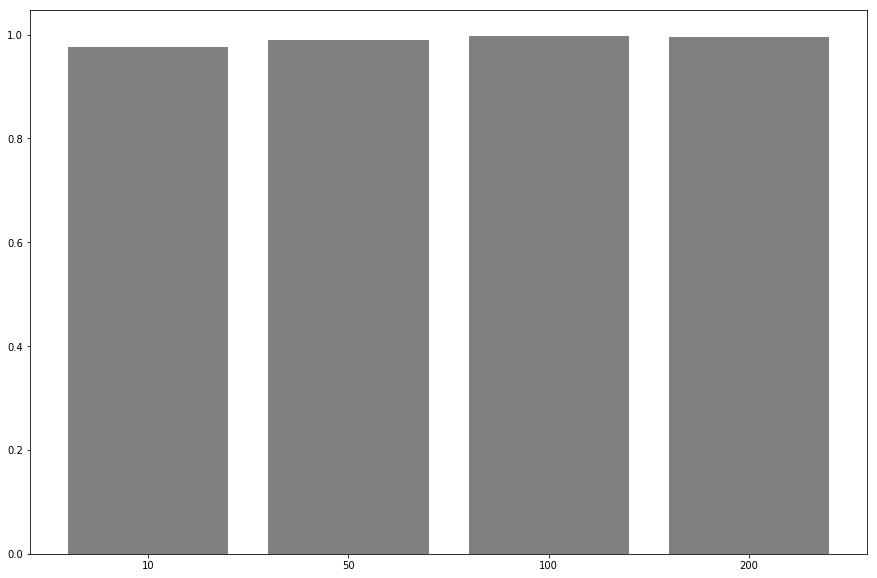

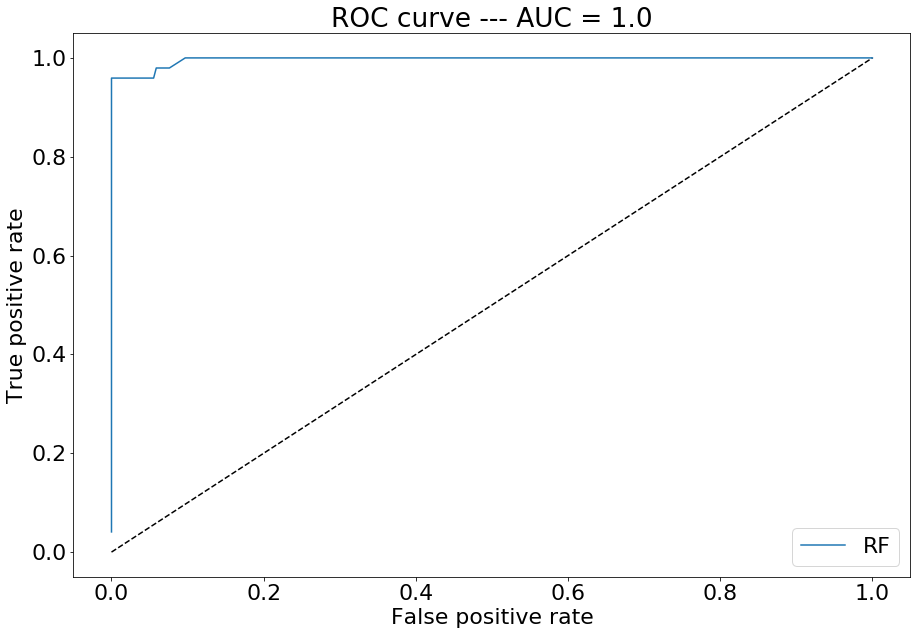

In [6]:
data_dir = r'TD\\'   
save_dir = r'TD\rf\\'
# read files and import to dataframe
df_label = pd.read_csv(os.path.join(data_dir, 'labels_Candidate.csv'), encoding='utf-8', header= None)

df_train = pd.read_csv(os.path.join(data_dir,'train.txt'),encoding = "ISO-8859-1", sep=',', header= None)

# Renaming column names
df_train.rename(columns =  {0: "id" ,2: "comments"}, inplace = True) 
df_label.rename(columns =  {0: "id" ,1: "lbl"}, inplace = True)

# Fill missing values with 0 (no 0 here)
#df_train.fillna(0,inplace=True)

# joining the words to generate sentences for each comment
df = df_train.groupby(["id"])["comments"].agg(lambda x: str(' '.join(x)))
df = pd.DataFrame({'id':df.index, 'lbl':df.values})


# merge dataframes to keep existing comments with labels
merged = pd.merge(left=df,right=df_label, how='left', left_on='id', right_on='id')

merged = pd.DataFrame({'comment':merged["lbl_x"], 'lbl':merged["lbl_y"]})

# finding number of labels to check if data is biased or not
print(merged.groupby("lbl").count())
#
merged.sort_values(by=['lbl'])
#

#
x_raw = merged["comment"]
x_raw = [clean_sent(sent) for sent in x_raw if len(sent.strip())>0]
y = np.array(merged["lbl"])
#
count = CountVectorizer()
bag = count.fit_transform(x_raw)
tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)
np.set_printoptions(precision=2)
x = tfidf.fit_transform(count.fit_transform(x_raw)).toarray()
# resampling the train and test sets, split label 0s in 3 parts, with all label 1s

c= 1154 #3464/3 number of lable 0s to be divided
#

#keeping all lable 1s
x_1 = np.concatenate((x[:c], x[3464:3999])) #x[:c] + x[3464:3999]
y_1 = np.concatenate((y[:c], y[3464:3999])) #y[:c] + y[3464:3999]

# shuffle x and y and split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    x_1, y_1, test_size=0.2,
    random_state=1,
    shuffle=True
)


# Random forests classifier on Lablelled data
trees = [10, 50, 100, 200]
fpr_rf_1 = dict()
tpr_rf_1 = dict()
auc_rf_1 = dict()
y_pred_rf_1 = []


for tree in trees:
    rf_1 = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rf_1.fit(x_train, y_train)

    y_pred_rf_1 = rf_1.predict_proba(x_test)[:, 1]
    fpr_rf_1[tree], tpr_rf_1[tree], _ = roc_curve(y_test, y_pred_rf_1)
    auc_rf_1[tree] = np.float32(auc(fpr_rf_1[tree], tpr_rf_1[tree]))

# plot auc vs tree numbers
auc_vals_1 = [auc_rf_1[tree] for tree in trees]

auc_barplot(auc_vals_1)
plt.savefig(os.path.join(save_dir, 'auc_vs_ntree_1.pdf'))
plt.show()

plot_roc_curv(fpr_rf_1[100], tpr_rf_1[100], auc_rf_1[100], method='RF')
plt.savefig(os.path.join(save_dir, 'roc_rf_100_trees_1.pdf'))
plt.show()



auc_vals = [0.8997923, 0.9279915, 0.93035156, 0.9296436]
### Number of trees = 100 has the highest accuracy.

We tested the accuracy of our Random Forest on existing labelled data. Now, to predict the unlabelled data we train the RF with 4000 records and predict the rest. At the end we compare the predictions for all approaches.

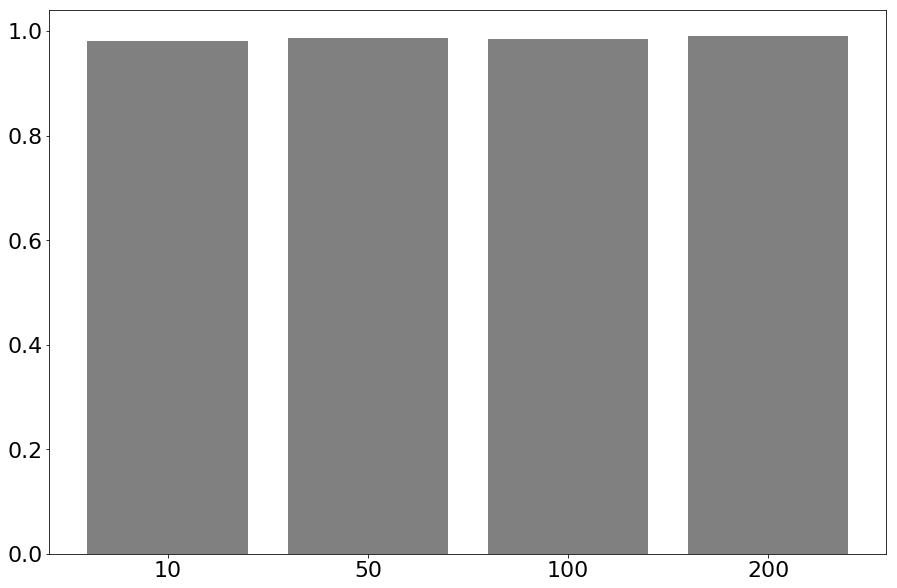

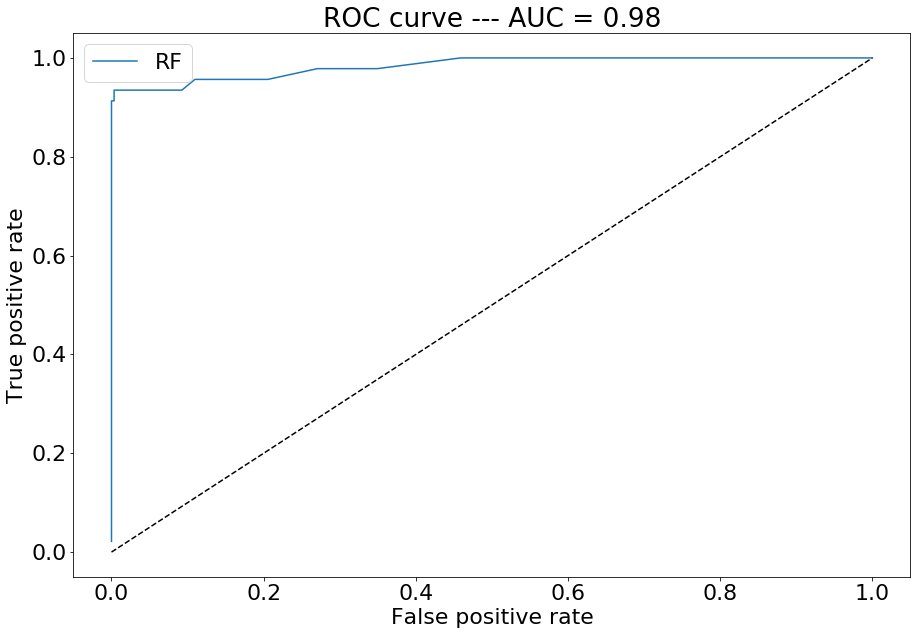

In [7]:
# second portion of data
x_2 = np.concatenate((x[c:c*2], x[3464:3999])) 
y_2 = np.concatenate((y[c:c*2], y[3464:3999]))
# shuffle x and y and split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    x_2, y_2, test_size=0.2,
    random_state=1,
    shuffle=True
)


# Random forests classifier on Lablelled data

fpr_rf_2 = dict()
tpr_rf_2 = dict()
auc_rf_2 = dict()
y_pred_rf_2 = []


for tree in trees:
    rf_2 = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rf_2.fit(x_train, y_train)

    y_pred_rf_2 = rf_2.predict_proba(x_test)[:, 1]
    fpr_rf_2[tree], tpr_rf_2[tree], _ = roc_curve(y_test, y_pred_rf_2)
    auc_rf_2[tree] = np.float32(auc(fpr_rf_2[tree], tpr_rf_2[tree]))

# plot auc vs tree numbers
auc_vals_2 = [auc_rf_2[tree] for tree in trees]

auc_barplot(auc_vals_2)
plt.savefig(os.path.join(save_dir, 'auc_vs_ntree_2.pdf'))
plt.show()

plot_roc_curv(fpr_rf_2[100], tpr_rf_2[100], auc_rf_2[100], method='RF')
plt.savefig(os.path.join(save_dir, 'roc_rf_100_trees_2.pdf'))
plt.show()



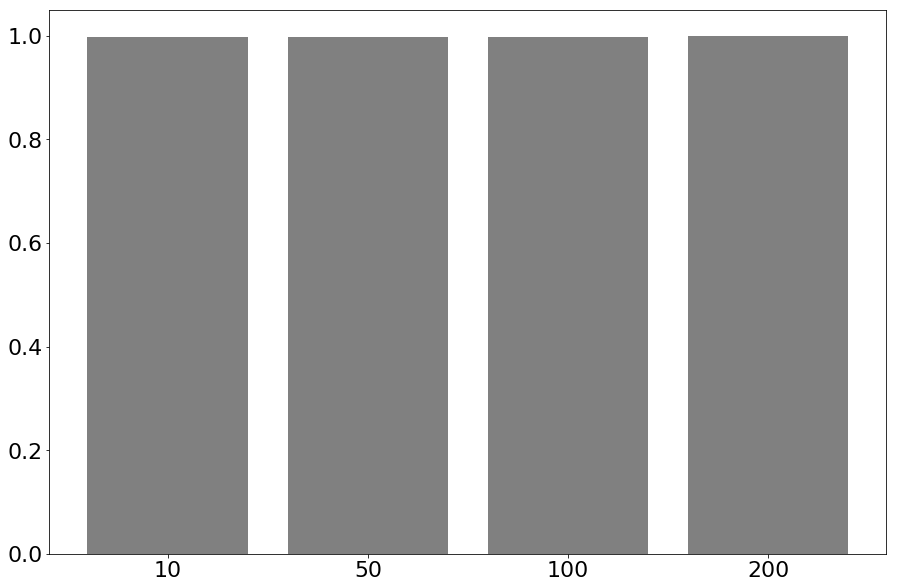

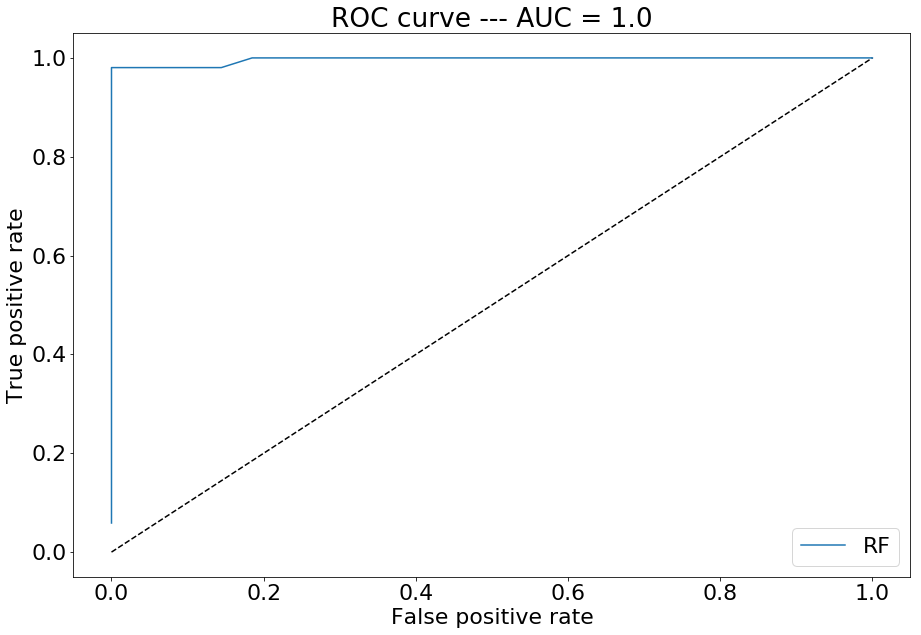

In [17]:
# third portion


x_3 = np.concatenate((x[c*2:3999], x[3464:3999])) 
y_3= list(y[c*2:3999])+ list(y[3464:3999])
y_3 = np.array(y_3)
# y_3 = np.concatenate((y[c*2:3999]+ y[3464:3999]))

# shuffle x and y and split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    x_3, y_3, test_size=0.2,
    random_state=1,
    shuffle=True
)


# Random forests classifier on Lablelled data

fpr_rf_3 = dict()
tpr_rf_3 = dict()
auc_rf_3 = dict()
y_pred_rf_3 = []


for tree in trees:
    rf_3 = RandomForestClassifier(n_estimators=tree, n_jobs=-1)
    rf_3.fit(x_train, y_train)

    y_pred_rf_3 = rf_3.predict_proba(x_test)[:, 1]
    fpr_rf_3[tree], tpr_rf_3[tree], _ = roc_curve(y_test, y_pred_rf_3)
    auc_rf_3[tree] = np.float32(auc(fpr_rf_3[tree], tpr_rf_3[tree]))

# plot auc vs tree numbers
auc_vals_3 = [auc_rf_3[tree] for tree in trees]

auc_barplot(auc_vals_3)
plt.savefig(os.path.join(save_dir, 'auc_vs_ntree_3.pdf'))
plt.show()

plot_roc_curv(fpr_rf_3[100], tpr_rf_3[100], auc_rf_3[100], method='RF')
plt.savefig(os.path.join(save_dir, 'roc_rf_100_trees_3.pdf'))
plt.show()



In [27]:
predict_labelled= [i+j+k for i,j,k in zip(rf_1.predict(x_test),rf_2.predict(x_test),rf_3.predict(x_test) )]

In [28]:
def vote(predict):
    vote=[]
    for i in predict:
        if i>1:
            vote.append(1)
        else:
            vote.append(0)
    return vote

In [29]:
# calculating F1 measure for the 3rd portion of data
y_pred = vote(predict_labelled)
f1_score(y_test, y_pred, average='weighted') 

0.9837956178008812

In [25]:
predict_test = [i+j+k for i,j,k in zip(rf_3.predict(x[3999:]),rf_3.predict(x[3999:]),rf_3.predict(x[3999:]) )]


In [22]:
y_pred_test = vote(predict_test)

In [24]:
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.to_csv(os.path.join(save_dir, 'rf_final_prediction.csv'), index= False)